In [ ]:
# Pytorch
# MNIST

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import torch.nn.functional as F

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [5]:
device

device(type='cuda')

In [6]:
from PIL import ImageOps

class AutocontrastTransform():
  def __call__(self, image):
    return ImageOps.autocontrast(image)

transform = transforms.Compose([
    AutocontrastTransform(),
    transforms.ToTensor()
])

train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)


train_loader = DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=64, shuffle=False)

100%|██████████| 9.91M/9.91M [00:02<00:00, 4.47MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 65.0kB/s]
100%|██████████| 1.65M/1.65M [00:06<00:00, 246kB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 6.03MB/s]


In [12]:
images , labels = next(iter(train_loader))

In [9]:
images.shape , labels.shape


(torch.Size([64, 1, 28, 28]), torch.Size([64]))

In [10]:
images[0].shape

torch.Size([1, 28, 28])

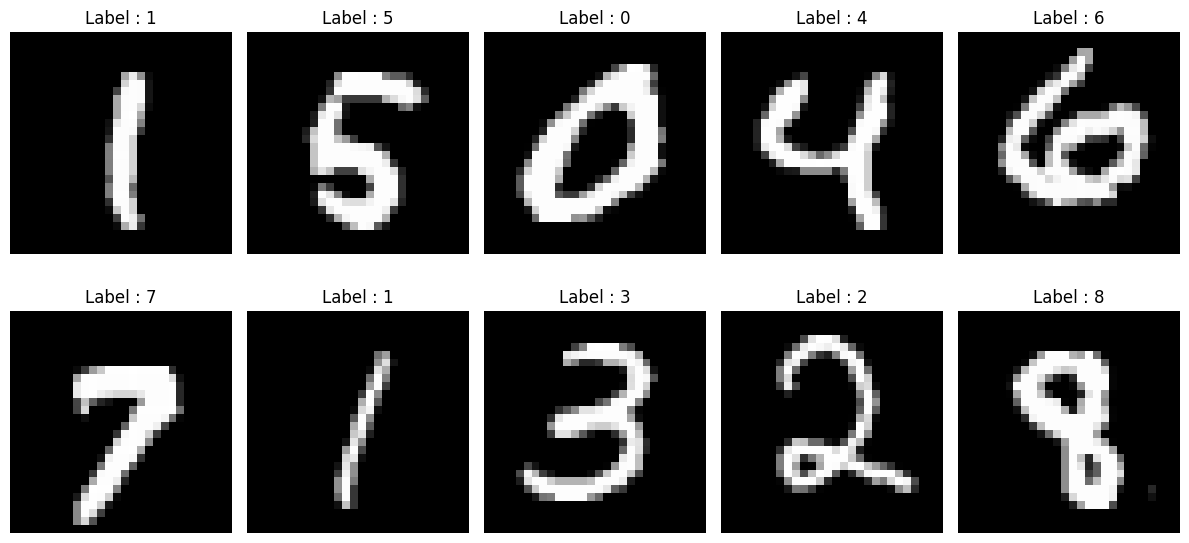

In [13]:
plt.figure(figsize=(12 , 6))

for i in range(10):
  plt.subplot(2 , 5 , i+1)
  plt.imshow(images[i].squeeze() , cmap='gray')
  plt.title(f"Label : {labels[i].item()}")
  plt.axis('off')

plt.tight_layout()
plt.show()

In [14]:
class MNISTClassifier(nn.Module):
  def __init__(self):
    super(MNISTClassifier , self).__init__()
    self.conv1 = nn.Conv2d(1, 32 , kernel_size=3)
    self.pool = nn.MaxPool2d(2,2)
    self.conv2 = nn.Conv2d(32, 64 , kernel_size=3)
    self.fc1 = nn.Linear(64*5*5 , 128)
    self.fc2 = nn.Linear(128 , 10)

  def forward(self , x):
    x = self.pool(F.relu(self.conv1(x)))
    x = self.pool(F.relu(self.conv2(x)))
    x = x.view(-1 , 64*5*5)
    x = F.relu(self.fc1(x))
    x = self.fc2(x)
    return x

In [15]:
model = MNISTClassifier().to(device)

In [16]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters() , lr=0.001)

In [17]:
epochs = 10
for epoch in range(epochs):
  running_loss = 0.0
  model.train()
  for i , (images , labels) in enumerate(train_loader):
    images = images.to(device)
    labels = labels.to(device)
    optimizer.zero_grad()
    outputs = model(images)
    loss = criterion(outputs , labels)
    loss.backward()
    optimizer.step()
    running_loss +=loss.item()
  print(f"Epoch {epoch+1}/{epochs} , Loss : {running_loss/len(train_loader)}")

Epoch 1/10 , Loss : 0.18196502618659446
Epoch 2/10 , Loss : 0.05406390383431533
Epoch 3/10 , Loss : 0.03767645316264743
Epoch 4/10 , Loss : 0.02792312663725775
Epoch 5/10 , Loss : 0.021519643906210705
Epoch 6/10 , Loss : 0.018445782013703386
Epoch 7/10 , Loss : 0.013106075900901945
Epoch 8/10 , Loss : 0.01074189459087065
Epoch 9/10 , Loss : 0.00917483158586278
Epoch 10/10 , Loss : 0.007599234960048355


In [18]:
model.eval()
correct = 0
total = 0

with torch.no_grad():
  for images , labels in test_loader:
    images = images.to(device)
    labels = labels.to(device)
    outputs = model(images)
    _, predicted = torch.max(outputs.data , 1)
    total += labels.size(0)
    correct += (predicted == labels).sum().item()

print(f"Test Accuracy : {100*correct/total}%")

Test Accuracy : 99.14%


In [19]:
torch.save(model , "model.pt")